<a href="https://colab.research.google.com/github/dmshlepakov/KG-TIES/blob/master/Create_Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install, Import Libs, Global Settings

In [0]:
! pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")


In [0]:
from collections import defaultdict
from gensim import corpora
from gensim import similarities
from gensim import models

In [0]:
! pip install rdfpandas
! pip install rdflib

import random
from tqdm.auto import tqdm

import pandas as pd
import json

import rdfpandas.graph
import rdfpandas as rpd

from rdflib.namespace import RDF
from rdflib import Graph
from rdflib import Literal

     |████████████████████████████████| 235kB 8.1MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 


In [0]:
#Open up MongoDB
!pip install pymongo
import pandas as pd
from pymongo import MongoClient

### Import Data

# Mongo Db Import Block

In [0]:
# Read-only credentials
mongouser = 'coronawhyguest'
mongopass = 'coro901na'
cordversion = 'v22'
client = MongoClient("mongodb://%s:%s@mongodb.coronawhy.org" % (mongouser, mongopass))
db = client.get_database('cord19')
collection = db.v22

In [100]:
#Get all trusted papers in list (via cord_uid)
corduid_list =  {'cord_uid': {"$in": [ 
                                        'l7eq3oeb',
                                        'xgp2vx6o',
                                        'gxk5t1yp',
                                        '8rfhwqp5',
                                        'txnegebz',
                                        'vkgnwxzc',
                                        'pc16duhj',
                                        'awgyxn3t'
                                     ] } }

doi_list = {'doi': {"$in": [ 
                              #'10.1101/2020.04.14.20065896', 
                              #'10.1016/j.jinf.2020.03.006',
                              #'10.1038/s41591-020-0869-5',
                              #'10.1101/2020.02.24.20027474',
                              #'10.1101/2020.03.10.20032136',
                              #'10.1101/2020.03.12.20034686', 
                              '10.1101/2020.03.15.20036533',
                              '10.1101/2020.03.24.20042382',
                              '10.1101/2020.03.26.20044826',
                              '10.15585/mmwr.mm6914e1',
                              '10.1101/2020.03.24.20042606',
                              '10.3760/cma.j.cn112150-20200227-00199',
                              '10.1101/2020.03.21.20040329',
                              '10.1101/2020.03.06.20031955'
                            ] } }
                  #  '10.1038/s41591-020-0869-5', - NOT in  CORD
                  #  '10.3760/cma.j.cn112150-20200227-00199', - NOT in CORD
                  #  '10.1101/2020.03.21.20040329',  - NOT in CORD
                  #  '10.1101/2020.03.06.20031955' - NOT in CORD

#metadata = collection.find(doi_list)
metadata = collection.find(corduid_list)
df = pd.DataFrame(metadata)
df

,_id,who_covidence_id,source_x,pmcid,pubmed_id,license,publish_time,authors,journal,mag_id,arxiv_id,s2_id,year,path,cord_uid,title,abstract,body_text,tables,body_rows
0,5ec6aa1750ceb4d90ad72618,~,Elsevier; Medline; PMC,PMC7194554,3.22832e+07,no-cc,2020-04-10,"Huang, Lei; Zhang, Xiuwen; Zhang, Xinyue; Wei, Zhijian; Zhang, Lingli; Xu, Jingjing; Liang, Peipei; Xu, Yuanhong; Zhang, Chengyuan; Xu, Aman",J Infect,~,~,2.15759e+08,2020,document_parses/pdf_json/541408c63b1bd096adc6fefa3354f10f3e0a0f4d.json/document_parses/pdf_json/541408c63b1bd096adc6fefa3354f10f3e0a0f4d.json/pdf_json/541408c63b1bd096adc6fefa3354f10f3e0a0f4d.json,8rfhwqp5,Rapid asymptomatic transmission of COVID-19 during the incubation period demonstrating strong infectivity in a cluster of youngsters aged 16-23 years outside Wuhan and characteristics of young pat...,[],[{'text': 'The outbreak of the 2019-novel-coronavirus-disease (COVID- 19) caused by severe-acute-respiratory-syndrome-coronavirus-2 (SARS-CoV-2) emerging from Wuhan in December 2019 has been arous...,"[[541408c63b1bd096adc6fefa3354f10f3e0a0f4d, FIGREF0, Patients 2, 3, and 8; the other patients remain in hospital. Values shown in bold indicate abnormal ones. ↑ , above the upper limit of the norm...","[{'cord_uid': '8rfhwqp5', 'section': 'title', 'subsection': 0, 'text': 'Rapid asymptomatic transmission of COVID-19 during the incubation period demonstrating strong infectivity in a cluster of yo..."
1,5ec68fa450ceb4d90ad6f71f,~,MedRxiv,~,~,medrxiv,2020-03-16,"Zhang, Che; Gu, Jiaowei; Chen, Quanjing; Deng, Na; Li, Jingfeng; Huang, Li; Zhou, Xihui",~,~,~,2.16482e+08,2020,document_parses/pdf_json/8ac9fa119b1818e217ab8c1f5b20b0d6a32c74ef.json/document_parses/pdf_json/8ac9fa119b1818e217ab8c1f5b20b0d6a32c74ef.json/pdf_json/8ac9fa119b1818e217ab8c1f5b20b0d6a32c74ef.json,awgyxn3t,Clinical Characteristics of 34 Children with Coronavirus Disease-2019 in the West of China: a Multiple-center Case Series,"[{'text': 'Background Up to 9 March, 2020, 109577 patients were diagnosed with', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]",[{'text': '47.60% of patients were noticed without any exposure history. The median incubation period was 10.50 (7.75 -25.25) days. Infections of other respiratory pathogens were reported in 16 pa...,"[[8ac9fa119b1818e217ab8c1f5b20b0d6a32c74ef, FIGREF0, -2019 (COVID-19) globally. The clinical and epidemiological characteristics of adult patients have been revealed recently. However, the informa...","[{'cord_uid': 'awgyxn3t', 'section': 'title', 'subsection': 0, 'text': 'Clinical Characteristics of 34 Children with Coronavirus Disease-2019 in the West of China: a Multiple-center Case Series'},..."
2,5ec690af50ceb4d90ad6f901,~,MedRxiv,~,~,medrxiv,2020-04-18,"Jiang, Ally Bi-zhu; Lieu, Richard; Quenby, Siobhan",~,~,~,2.16055e+08,2020,document_parses/pdf_json/3dac6b5cc9ca97a44c1553cd96d6ba69593296eb.json/document_parses/pdf_json/3dac6b5cc9ca97a44c1553cd96d6ba69593296eb.json/pdf_json/3dac6b5cc9ca97a44c1553cd96d6ba69593296eb.json,gxk5t1yp,"Significantly longer Covid-19 incubation times for the elderly, from a case study of 136 patients throughout China","[{'text': 'Objective: To infer Covid-19 incubation time distribution from a large sample.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'Method: Based on individual case da...","[{'text': 'The incubation time of Covid-19 [1] and the closely related question of asymptomatic case numbers are two topics of major interest and concern. On the former, the research results prese...","[[3dac6b5cc9ca97a44c1553cd96d6ba69593296eb, FIGREF0, the incubation time we report below is significantly longer. For nearly every city in China, daily information on list of COVID-19 cases is rel...","[{'cord_uid': 'gxk5t1yp', 'section': 'title', 'subsection': 0, 'text': 'Significantly longer Covid-19 incubation times for the elderly, from a case study of 136 patients throughout China'}, {'cord..."
3,5ec66d5250ceb4d90ad6bab5,~,PMC,PMC56579

In [101]:
# Get altmetrics
altmetricsdb = client.get_database('altmetrics')
altcollection = altmetricsdb[cordversion]
metadata = altcollection.find(corduid_list)
alt_df = pd.DataFrame(metadata)
alt_df

""


In [102]:
# Extracting sentences preventing broken sentences

sentences = []
previtem = ''

for br in df.body_rows.values:
  for item in br:
    if item['subsection'] != 0:
      if item['text'].endswith("."):
        sentences.append(previtem + item['text'])
        previtem = ''
      else:
        previtem = item['text'] + ' ' 
           
sentences

['We collected and analyzed detailed data from a cluster of youngsters aged 16-23 years with laboratory-confirmed COVID-19 in Hefei, China, originating from a 22-year-old youngster (Patient-Index) returning from Wuhan who rapidly transmitted COVID-19 to seven other youngsters of similar ages without recent travel to Wuhan, where rapid transmission had occurred during the incubation-period of illness in Patient-Index. We also identified all the SARS-CoV-2-negative close-contacts of Patient-Index, and further compared them with the SARS-CoV-2-positive patients. We carefully examined the infectivity and transmission dynamics by obtaining valid information directly from the patients and contacts themselves. We are herein describing the demographic, epidemiological, clinical, radiological, and laboratory features, management, and outcomes of the cluster of youngsters with COVID-19 and also the SARS-CoV-2-negative close-contacts.',
 'The data that support the findings of this study are all i

# **TIES Domain modelling**
 * Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
 * Prevalence of asymptomatic shedding and transmission (e.g., particularly children).
 * Seasonality of transmission.
 * Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).
 * Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).
 * Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
 * Natural history of the virus and shedding of it from an infected person
 * Implementation of diagnostics and products to improve clinical processes
 * Disease models, including animal models for infection, disease and transmission
 * Tools and studies to monitor phenotypic change and potential adaptation of the virus
 * Immune response and immunity
 * Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings
 * Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings
 * Role of the environment in transmission

Rule-based matching is supervised technique of labeling token series by presribed rules or patterns.

# Ontology Dictionary

In [0]:
def pasteTuple(inp_tuple):
  
  return(str(inp_tuple[0]) + ' ' + str(inp_tuple[1]) + ' ' + str(inp_tuple[2]))

In [0]:
#
# Class to handle all Dictionary functions and properties
#
class OntologyDictionary:
    
    def __init__(self, ontology=None):
      # Initial (constructor) dictionary
       self.ontology = [
              ('incubation period', 'mean', 'day'),
              ('incubation period', 'standard deviation', 'day'),
              ('incubation period', 'average', 'day'),
              ('patient', 'age', 'year'),
              ('patient', 'age', 'children'),
              ('patient', 'age', 'teenager'),
              ('patient', 'age', 'adult'),
              ('patient', 'health status', ''),
              ('contageous period', 'minimum', 'day'),
              ('contageous period', 'maximum', 'day'),
              ('asymptomatic shedding', 'share', ''),
              ('persistent', 'copper', 'hour'),
              ('persistent', 'stainless steel', 'hour'),
              ('persistent', 'plastic', 'hour'),
              ('shedding', '', '')
              ]

    def addRelation(self, entity, prop="", value=""):
    
      try: 
        self.ontology.append((entity, prop, value))
      except ValueError:
        print("Entity cannot be empty!")
      return()

    def convertOntologyToVectors(self, topics=2):
    
      self.VectorDict = corpora.Dictionary(self.ontology)
      self.VDCorpus = [self.VectorDict.doc2bow(text) for text in self.ontology]

      self.lsi = models.LsiModel(self.VDCorpus, id2word=self.VectorDict, num_topics=topics)    
      self.index = similarities.MatrixSimilarity(self.lsi[self.VDCorpus]) 
      self.index.save('/tmp/deerwester.index')
      self.index = similarities.MatrixSimilarity.load('/tmp/deerwester.index')
      return()  

    def convertOntologyToDataframe(self):
    
      self.ontology.asDF = pd.DataFrame(self.ontology, columns=[':entity', ':property', ':value'])
      return()   
  
    def getSimilarity(self, phrase):
  
      vec_bow = self.VectorDict.doc2bow(phrase.lower().split())
      vec_lsi = self.lsi[vec_bow] 
    
      # Perform a similarity query against the corpus
      sims = self.index[vec_lsi]  
      print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples
      sims = sorted(enumerate(sims), key=lambda item: -item[1])
      for i, s in enumerate(sims):
        print(s, self.ontology[i])
  
      return(sims) 
    
    def getOntology(self, ont=[]):

      self.ontology = ont
      return()

    def importOntology(self, uri=''):

      return()

## Dependency parsing

Dependency parsing is unsupervised technique based on common (statistically prevalent) linguistic structure of sentence. There is no semantic analysis or domain knowledge inside. It's fast performance wise and quite abstract in research. Dependency parsing is necessary to refine initial entities those are sufficient to include the whole ontology.

In [0]:
def getEntities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [0]:
def getRelation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [
              {'DEP':'ROOT'}, 
              {'DEP':'prep','OP':"?"},
              {'DEP':'agent','OP':"?"},  
              {'POS':'ADJ','OP':"?"}
            ] 

  matcher.add(":relates", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [56]:
# Ingesting ontology dictionary
ont_dic = OntologyDictionary()
ont_dic.ontology

[('incubation period', 'mean', 'day'),
 ('incubation period', 'standard deviation', 'day'),
 ('incubation period', 'average', 'day'),
 ('patient', 'age', 'year'),
 ('patient', 'age', 'children'),
 ('patient', 'age', 'teenager'),
 ('patient', 'age', 'adult'),
 ('patient', 'health status', ''),
 ('contageous period', 'minimum', 'day'),
 ('contageous period', 'maximum', 'day'),
 ('asymptomatic shedding', 'share', ''),
 ('persistent', 'copper', 'hour'),
 ('persistent', 'stainless steel', 'hour'),
 ('persistent', 'plastic', 'hour'),
 ('shedding', '', '')]

In [57]:
ont_list = []
for d in ont_dic.ontology:
  ont_list.append(pasteTuple(d))
ont_list

['incubation period mean day',
 'incubation period standard deviation day',
 'incubation period average day',
 'patient age year',
 'patient age children',
 'patient age teenager',
 'patient age adult',
 'patient health status ',
 'contageous period minimum day',
 'contageous period maximum day',
 'asymptomatic shedding share ',
 'persistent copper hour',
 'persistent stainless steel hour',
 'persistent plastic hour',
 'shedding  ']

In [0]:
ont_tokens = [
    [word for word in d.lower().split()]
    for d in ont_list
]

dictionary = corpora.Dictionary(ont_tokens)
corpus = [dictionary.doc2bow(t) for t in ont_tokens]

In [0]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)

In [60]:
index = similarities.MatrixSimilarity(lsi[corpus])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [61]:
index.save('/tmp/deerwester.index')
index = similarities.MatrixSimilarity.load('/tmp/deerwester.index')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [103]:
# Finding candidate entity pairs Subject to Value
entity_pairs = []

for i in tqdm(sentences):
  entity_pairs.append(getEntities(i))

In [104]:
# Finding candidate properties
properties = [getRelation(i) for i in tqdm(sentences)]

In [0]:
# get prepared triples
entities = [i[0] for i in entity_pairs]
values = [i[1] for i in entity_pairs]

In [106]:
phrase_list = []
for e, p, v in zip(entities, properties, values):
  phrase_list.append(pasteTuple([e, p, v]))
phrase_list

['directly  We are demographic  COVID-19',
 'additional  data included in manuscript',
 'study researchers confirm funders',
 'who confirmed with COVID-19 both  January',
 'closely healthcare they tested negative negative SARS CoV-2',
 'None had exposure',
 '27 Patient We find microbiological  testing',
 'mm  They wore special illness onset',
 'positive SARS which 4 COVID-19  diagnosis',
 '11  symptoms described in Supplementary Supplementary illness results',
 'few illness infiltrates noticed in left  lung',
 'Most C reactive patients had normal available serum information',
 'CoV-2-positive C reactive Management detailed in Supplementary Supplementary  results',
 'serial illness interval defined as successive transmission chain',
 'potential I findings interpreted as potential Mann Whitney type',
 'contact details shown in Supplementary Supplementary  results',
 'strong index symptoms had fast fast  onset',
 'None reported ',
 'We formed team prospectively following contacts',
 'Info

In [0]:
sim_threshold = 0.6
cand_df = pd.DataFrame({':entity':entities, ':property':properties, ':value':values})
#kg_df = cand_df.apply(pasteTuple, axis=0)
# Check validity of candidate tuples
drop_ind = []
for i, phr in enumerate(phrase_list, start = 0):
    vec_bow = dictionary.doc2bow(phr.lower().split())
    # convert the relation to LSI space
    vec_lsi = lsi[vec_bow]  
    sims = index[vec_lsi]  # perform a similarity query against the corpus
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    if sims[0][1] < sim_threshold:
      drop_ind.append(i)
      
      
kg_df = cand_df.drop(cand_df.index[drop_ind], inplace=False)


In [114]:
print(kg_df)
drop_ind

                             :entity  ...                                 :value
6                      27 Patient We  ...               microbiological  testing
22   13 National Health examinations  ...                 Supplementary  methods
29                               age  ...                          illness onset
32                          L. Huang  ...           tracing incubation Infection
35                                    ...           tracing incubation Infection
38                  1 Wuhan epidemic  ...     international World Health January
39         However adult information  ...                   paediatric  patients
43                 limited  findings  ...                early epidemic children
44          median incubation period  ...            paediatric disease COVID-19
57              dynamic  observation  ...             extended incubation period
62             previous adult levels  ...                myocardial α impairment
68          median incubatio

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 33,
 34,
 36,
 37,
 40,
 41,
 42,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 88,
 89,
 91,
 92,
 94,
 95,
 96,
 97,
 99,
 100,
 101,
 102,
 103,
 104,
 108,
 109,
 110,
 111,
 112,
 113,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 130,
 131,
 133,
 134,
 137,
 138,
 139,
 140,
 141,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169]

## Knowledge Graph Visual Representation

In [0]:
import re
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)

%matplotlib inline

In [116]:
print(kg_df)

                             :entity  ...                                 :value
6                      27 Patient We  ...               microbiological  testing
22   13 National Health examinations  ...                 Supplementary  methods
29                               age  ...                          illness onset
32                          L. Huang  ...           tracing incubation Infection
35                                    ...           tracing incubation Infection
38                  1 Wuhan epidemic  ...     international World Health January
39         However adult information  ...                   paediatric  patients
43                 limited  findings  ...                early epidemic children
44          median incubation period  ...            paediatric disease COVID-19
57              dynamic  observation  ...             extended incubation period
62             previous adult levels  ...                myocardial α impairment
68          median incubatio

In [0]:
def DrawKG(knowledgegraph_df):
  
  # create a directed-graph from a dataframe
  G = nx.from_pandas_edgelist(knowledgegraph_df, ":entity", ":value", edge_attr=True, create_using=nx.MultiDiGraph())
  
  plt.figure(figsize=(16,16))

  pos = nx.spring_layout(G)
  nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
  plt.show()

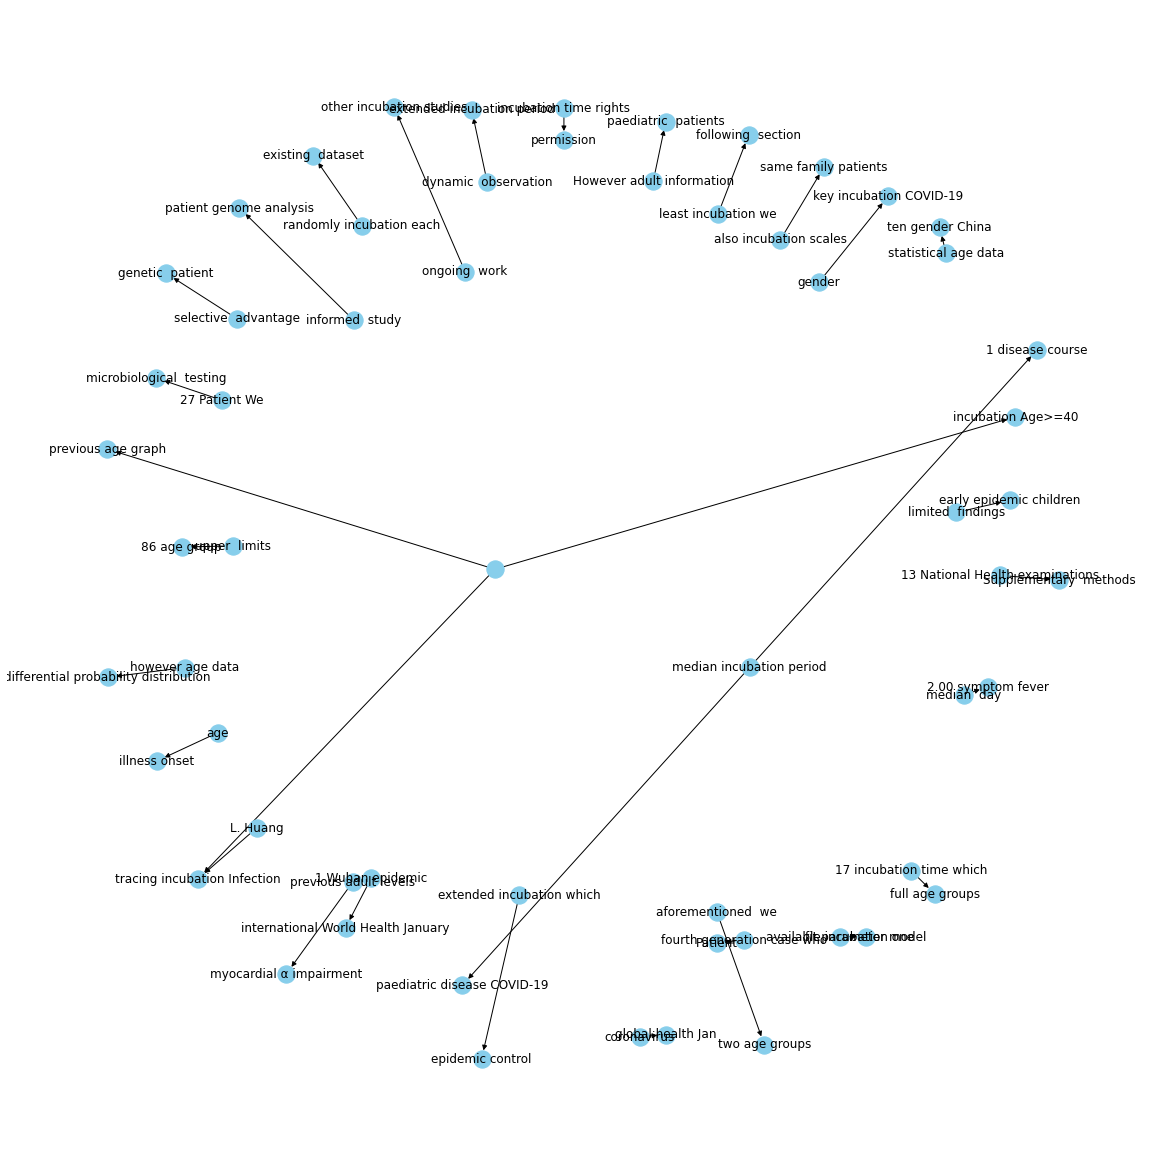

In [118]:

DrawKG(kg_df)

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

DrawKG(kg_df)

NameError: ignored

# Export to CSV/RDF

In [0]:
# Export to RDF 

g = Graph()
g.bind("rdf", RDF)

for index, row in kg_df.iterrows(): 
  g.add((Literal(row[':entity']), Literal(row[':property']), Literal(row[':value'])))

print(g)

[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory']].


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# RDF turtle should be serialized to write it properly

root = os.getcwd()
filepath = '/gdrive/My Drive/COVID-19'
cwd = os.path.join(root, filepath)
os.chdir(cwd)

file = open("ties-kg.rdf", mode="wb")
g.serialize(destination='ties-kg.rdf', format='turtle')

In [0]:
#Export to TSV

kg_df.to_csv('ties_kg.tsv', sep='\t', encoding='utf-8', index=False)

In [0]:
import os
print(os.listdir())

['data', 'dataverse', 'ties-kg.rdf']


## Debugging TAGS, POS, LABEL

In [0]:
t = []
t.append('In a sensitivity analysis, we vary the incubation period from 1 day to 3 days, the infectious period from 5 days to 7 days, and the latent period from 0 days to 1 day.')
t.append('We reviewed the literature for the epidemiological parameters: incubation period, infectious period, hospitalization period, hospitalized proportion, case fatality proportion, and R 0 .')
t.append('Assuming that the latent period and the infectious period is approximately equal to the incubation period and the length of stay, the mean values of the latent period and the infectious period are preliminarily estimated to be 5 and 10 days, respectively.')
t.append('Measles (incubation period of 7-18 days), mumps (incubation period of 12-25 days), rubella (incubation period of 14-23 days), and varicella (incubation period of 10-21 days) are relevant examples.')
t.append('In the primary analysis, we assumed an incubation period of 2 days, a latent period of 0 days, and an infectious period of 6 days.')
t.append('The average incubation period is 5-6 days with the longest incubation period of 14 days.')
t.append('Incubation period: 14–21 days')

In [0]:
doc = nlp(t[0])

print("{: <12} {: <12} {: <8} {: <6} {: <8} {: <8}".format("Text", "Lemma", "POS", "Tag", "Dep", "Shape"))
print("------------------------------------------------------------")
for token in doc:
    print("{: <12} {: <12} {: <8} {: <6} {: <8} {: <8} {: <8}".format(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.orth))

In [0]:
from spacy import displacy

# 'From our definition of incubation period, his incubation period will be 28 days, which is surprisingly high.'
doc = nlp(t[0])
displacy.render(doc, style='dep', jupyter=True, options={'distance': 80, "fine_grained": True})

### Not tested placeholders

In [0]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")

ties = ["transmission", "incubation period", "incubation"]
ties_patterns = list(nlp.pipe(ties))
print("TIES patterns:", ties_patterns)
matcher = PhraseMatcher(nlp.vocab)
matcher.add("TIES", None, *ties_patterns)

# Define the custom component
def TIES_component(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label "TIES"
    spans = [Span(doc, start, end, label="TIES") for match_id, start, end in matches]
    # Overwrite the doc.ents with the matched spans
    doc.ents = spans
    return doc


# Add the component to the pipeline after the "ner" component
nlp.add_pipe(TIES_component, after="ner")
print(nlp.pipe_names)

# Process the text and print the text and label for the doc.ents
doc = nlp(sentences[30])
print([(ent.text, ent.label_) for ent in doc.ents])

In [0]:
docs = list(nlp.pipe(TEXT))
entities = [doc.ents for doc in docs]
print(*entities)

In [0]:
# Depricated
def getPeriodEntities(modifier, sentence):
  
  # Language and Vocabulary setting - English small model
  nlp = spacy.load("en_core_web_sm")
  
  matcher = Matcher(nlp.vocab)
  doc = nlp(sentence)
   
  # 1) "Incubation period"  2) "infection period"
  pattern = [
              {'LEMMA': modifier}, {'LEMMA': 'period'}
            ]

  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add(":entityPeriod", None, pattern)
  matches = matcher(doc)
  
  entities = []
  
  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
    entities.append(doc[end].orth, doc[start:end].text)
    for c in doc[end].token.children:
        crossid.append(c.orth, ent_id)
    
  return(entities)
  

In [0]:
# Depicated
def getPersistenceEntities(sentence):
  
  # Language and Vocabulary setting - English small model
  nlp = spacy.load("en_core_web_sm")
  
  matcher = Matcher(nlp.vocab)
  doc = nlp(sentence)
   
  # Virus survives on <surface>
  pattern_pers = [ 
                  {"LEMMA": "persist"}, {"POS": "on"}, {"POS": "NOUN"}, {"OP": "*"}
                 ]
  pattern_surv = [ 
                  {"LEMMA": "survive"}, {"POS": "on"}, {"POS": "NOUN"}, {"OP": "*"}
                 ]
  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add(":entityPersistence", None, pattern_pers, pattern_surv)
  matches = matcher(doc)
  
  entities = []
  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
    entities.append(doc[start:end].text)
     
  return(entities)

In [0]:
# Depricated
def getPeriodProperties(sentence):
  
  # Language and Vocabulary setting - English small model
  nlp = spacy.load("en_core_web_sm")
  
  matcher = Matcher(nlp.vocab)
  doc = nlp(sentence)

  statistics = [ 'minimum', 'maximum', 'average', 'mean'] 
  # "Incubation period maximum is about/approximately 14 days"
  
  patterns = [[{"LEMMA": stat}] for stat in statistics] 
  
  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add(":property", None, *patterns)
  matches = matcher(doc)
  
  properties = []
  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
    properties.append(doc[end].token.orth, doc[start:end].text)
     
  return(properties)


In [0]:
# Depricated
def getPeriods(sentence):
  
  # Language and Vocabulary setting - English small model
  nlp = spacy.load("en_core_web_sm")
  
  matcher = Matcher(nlp.vocab)
  doc = nlp(sentence)
   
  # 1) "2-14 days" 2) "from 7 to 14 days." 3) "<5.2 days" 4) "~4-12 days" 5)
  pattern = [ 
              #{"POS":"X", "OP":"?", "POS":"NUM", "OP":"?", "POS":"HYPH", "OP":"?",
               {"POS":"NUM"}, {"LEMMA":"day"}#,
             # {"POS":"X", "OP":"?", "POS":"NUM", "OP":"?", "POS":"HYPH", "OP":"?", "POS":"NUM", "LEMMA":"hour"},
              #{"POS":"X", "OP":"?", "POS":"NUM", "OP":"?", "POS":"HYPH", "OP":"?", "POS":"NUM", "LEMMA":"week"} 
            ]
  
  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add(":period", None, pattern)
  matches = matcher(doc)
  
  period_values = []
  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
    period_values.append(doc[end].token.orth, doc[start:end].text)
    
  return(period_values)


In [0]:
# depricated
def getPersistenceMaterials(sentence):
  
  # Language and Vocabulary setting - English small model
  nlp = spacy.load("en_core_web_sm")
  
  matcher = Matcher(nlp.vocab)
  doc = nlp(sentence)
   
  # Surfaces
  pattern_pap = [ 
                  {"LEMMA": "paper"}
                 ]
  pattern_pl = [ 
                  {"LEMMA": "plastic"}
               ]
  pattern_met = [ 
                  {"POS": "ADJ" }, {"OP": "?"}, {"LEMMA": "steel"}
               ]
  pattern_gl = [ 
                  {"LEMMA": "glass"}
               ]

  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add(":entitySurface", None, pattern_pap, pattern_pl, pattern_met, pattern_gl)
  matches = matcher(doc)
  
  entities = []
  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
    entities.append(doc[start:end].text)
     
  return(entities)